# Download NYC Subway Dataset

In [ ]:
# https://transitfeeds.com/p/mta/79

# https://mobilitydatabase.org/feeds/mdb-516?utm_source=transitfeeds&utm_medium=redirect&utm_campaign=site_migration

In [3]:
pip install contextily

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import random
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import osmnx as ox
import networkx as nx
from shapely.ops import unary_union
from shapely.geometry import Polygon, MultiPolygon

import contextily as cx
from tqdm import tqdm
import imageio.v2 as imageio
from IPython.display import Image, display

# Prepare the GTFS Data

<Axes: >

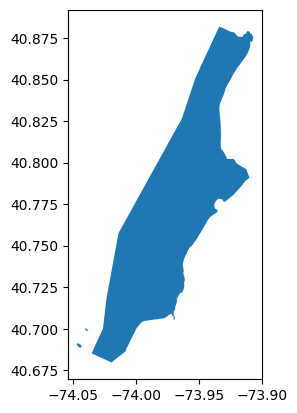

In [2]:
admin = ox.geocode_to_gdf('Manhattan')
admin.plot()

In [3]:
stops = pd.read_csv('7. NYC Subway GTFS/stops.txt')
stops.head()

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station
0,101,Van Cortlandt Park-242 St,40.889248,-73.898583,1.0,NaN
1,101N,Van Cortlandt Park-242 St,40.889248,-73.898583,NaN,101
2,101S,Van Cortlandt Park-242 St,40.889248,-73.898583,NaN,101
3,103,238 St,40.884667,-73.900870,1.0,NaN
4,103N,238 St,40.884667,-73.900870,NaN,103


In [4]:
stops_gdf = gpd.GeoDataFrame(
    stops, 
    geometry=gpd.points_from_xy(stops.stop_lon, stops.stop_lat),
    crs='EPSG:4326'
)

print(len(stops_gdf))
stops_gdf.head(3)

1488


,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station,geometry
0,101,Van Cortlandt Park-242 St,40.889248,-73.898583,1.0,NaN,POINT (-73.89858 40.88925)
1,101N,Van Cortlandt Park-242 St,40.889248,-73.898583,NaN,101,POINT (-73.89858 40.88925)
2,101S,Van Cortlandt Park-242 St,40.889248,-73.898583,NaN,101,POINT (-73.89858 40.88925)


<Axes: >

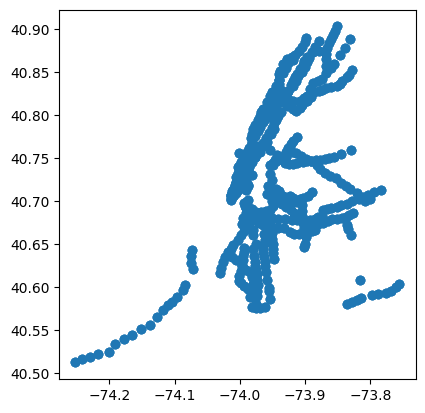

In [5]:
stops_gdf.plot()

459

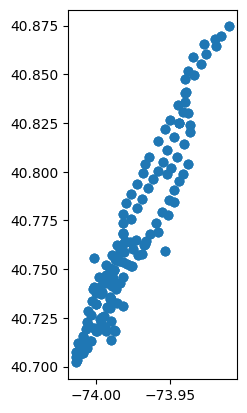

In [6]:
# to select only data in manhattan
stops_gdf = gpd.overlay(stops_gdf, admin[['geometry']])
stops_gdf.plot()
len(stops_gdf)

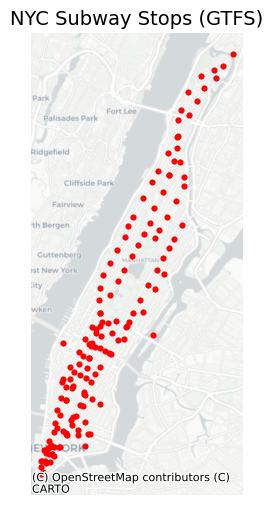

In [7]:
fig, ax = plt.subplots(figsize=(4,6))
stops_gdf.plot(ax=ax, color='red', markersize=10, alpha=0.7)
cx.add_basemap(ax, crs=stops_gdf.crs, source=cx.providers.CartoDB.Positron)
ax.set_title('NYC Subway Stops (GTFS)', fontsize=14)
ax.set_axis_off()
plt.show()

# Isochrones from a Random Station

In [8]:
random_stop = stops_gdf.sample(1).iloc[0]
print(f"Selected Stop: {random_stop['stop_name']}")

Selected Stop: W 4 St-Wash Sq


In [9]:
center_point = (random_stop.stop_lat, random_stop.stop_lon)
center_point

(40.732338, -74.000495)

In [10]:
G = ox.graph_from_point(center_point, dist=1000, network_type='walk')
type(G)

networkx.classes.multidigraph.MultiDiGraph

In [11]:
G.number_of_nodes()

2549

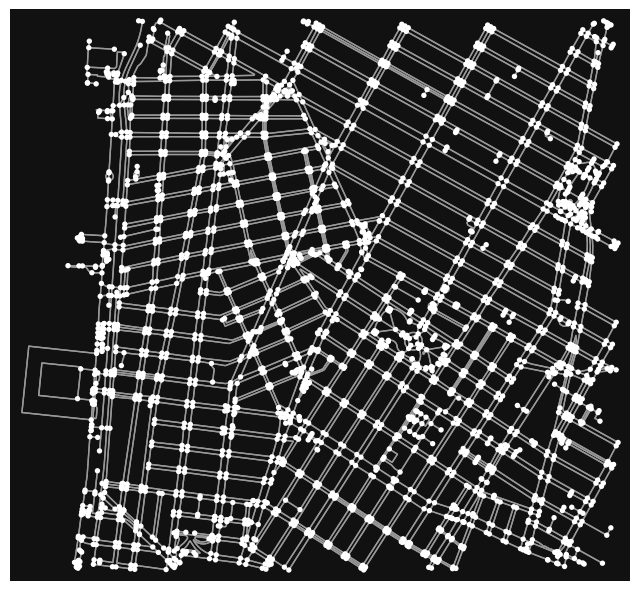

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [12]:
ox.plot_graph(G)

In [13]:
#Compute edge of every road segment
edge_lengths = [d.get('length', 0) for _, _, _, d in G.edges(keys=True, data=True)]
print(f"Average edge length: {sum(edge_lengths):.1f} meters")

# for every edge add walk time attribute computed from road length and average walking speed
# walking speed = 5km/hr = 83.33 m/min
for u, v, k, data in G.edges(keys=True, data=True):
    data['walk_time_min'] = data['length'] / 83.33

Average edge length: 328650.0 meters


In [14]:
# Isochrone is a boundary line which shows all the road intersections which are in the same distance from the center  

In [15]:
# get center
center_node = ox.nearest_nodes(G, X=center_point[1], Y=center_point[0])
center_node

8309478818

In [16]:
# compute isochrones for diff time thresholds
time_thresholds = list(range(1,11))
time_thresholds

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [17]:
iso_polygons = []

# iterate over each time thresh
for minutes in time_thresholds:
    # all nodes within the radius from the center node
    subgraph = nx.ego_graph(G, center_node, radius=minutes, distance='walk_time_min')
    # get nodes and edges
    nodes, edges = ox.graph_to_gdfs(subgraph, nodes=True, edges=True)
    # measure in meters using web mercator
    edges_proj = edges.to_crs(3857)
    poly = edges_proj.buffer(25).union_all()
    gdf_poly = gpd.GeoSeries([poly], crs=3857).to_crs(4326)
    iso_polygons.append((minutes, gdf_poly.iloc[0]))

In [18]:
iso_polygons[0]

(1,
 <POLYGON ((-74.001 40.732, -74.001 40.732, -74.001 40.732, -74.001 40.732, -...>)

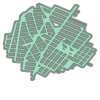

In [19]:
iso_polygons[-1][1]

<Axes: >

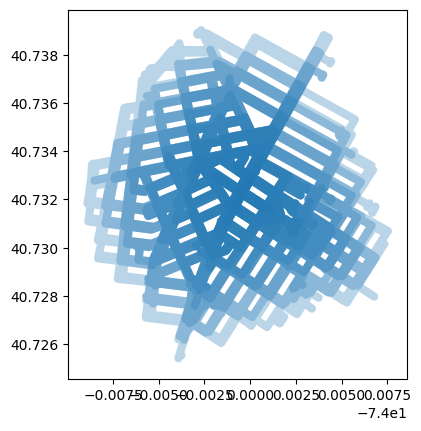

In [20]:
iso_gdf = gpd.GeoDataFrame(
    [
        {"minutes":m, "geometry":poly} for m, poly in iso_polygons if poly and not poly.is_empty], crs="EPSG:4326"
)

iso_gdf.plot(alpha=0.3)

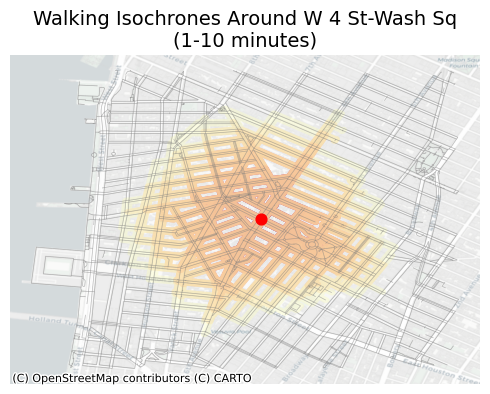

In [21]:
fig, ax = plt.subplots(figsize=(5,5))
for idx, row in iso_gdf.iterrows():
    color = plt.cm.magma(row['minutes'] / iso_gdf['minutes'].max())
    gpd.GeoSeries([row.geometry]).plot(ax=ax, color=color, alpha=0.4, edgecolor='none')

edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
edges.plot(ax=ax, linewidth=0.5, color='gray', alpha=0.3, zorder=1)

gpd.GeoSeries([random_stop.geometry]).plot(ax=ax, color='red', markersize=60, zorder=5)

cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.CartoDB.Positron)

ax.set_title(f"Walking Isochrones Around {random_stop['stop_name']}\n(1-10 minutes)", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

# Creating Isochrones for a series of Sample Locations

In [22]:
WALK_SPEED = 83.33
BUFFER_METERS = 25
CRS_METRIC = 3857
CRS_GEO = 4326

def get_walk_graph(lat, lon, dist=1000):
    G = ox.graph_from_point((lat,lon), dist=dist, network_type='walk')

    for u, v, k, data in G.edges(keys=True, data=True):
        data['walk_time_min'] = data['length'] / WALK_SPEED
    return G

def compute_isochrones(G, lat, lon, minutes, range=range(1,11)):
    center_node = ox.nearest_nodes(G, X=lon, Y=lat)
    iso_polygons = []

    for minutes in time_thresholds:
        subgraph = nx.ego_graph(G, center_node, radius=minutes, distance='walk_time_min')
        if subgraph.number_of_edges() == 0:
            continue
        _, edges = ox.graph_to_gdfs(subgraph, nodes=True, edges=True)
        edges_proj = edges.to_crs(CRS_METRIC)
        poly = edges_proj.buffer(BUFFER_METERS).union_all()
        gdf_poly = gpd.GeoSeries([poly], crs=CRS_METRIC).to_crs(CRS_GEO)
        iso_polygons.append((minutes, gdf_poly.iloc[0]))
    return iso_polygons

def make_iso_gdf(iso_polygons):
    return gpd.GeoDataFrame(
        [{"minutes":m, "geometry":p} for m, p in iso_polygons if p and not p.is_empty], crs=f"EPSG:{CRS_GEO}"
    )

def compute_isochrones(G, lat, lon, max_minutes=15, step_seconds=5):
    time_thresholds = np.arange(0, max_minutes + step_seconds/60, step_seconds/60)

    center_node = ox.nearest_nodes(G, lat, lon)
    iso_polygons = []

    for minutes in time_thresholds:
        subgraph = nx.ego_graph(G, center_node, radius=minutes, distance='walk_time_min')
        if subgraph.number_of_edges() == 0:
            continue
        _, edges = ox.graph_to_gdfs(subgraph, nodes=True, edges=True)
        edges_proj = edges.to_crs(CRS_METRIC)
        poly = edges_proj.buffer(BUFFER_METERS).union_all()
        gdf_poly = gpd.GeoSeries([poly], crs=CRS_METRIC).to_crs(CRS_GEO)
        iso_polygons.append((minutes, gdf_poly.iloc[0]))
    return iso_polygons


In [23]:
# select 10 random stops
subset_stops = stops_gdf.copy().reset_index(drop=True).sample(10, random_state=42).reset_index(drop=True)

all_isochrones=[]

for i, stop in tqdm(subset_stops.iterrows(), total=len(subset_stops), desc='Computing Isochrones'):
    lat, lon = stop.stop_lat, stop.stop_lon
    G = get_walk_graph(lat, lon, dist=1000)
    iso_polygons = compute_isochrones (G, lat, lon, max_minutes=15, step_seconds=5)
    iso_gdf = make_iso_gdf(iso_polygons)

    iso_gdf['station'] = stop['stop_name']
    all_isochrones.append(iso_gdf)

Computing Isochrones: 100%|████████████████████████████████████████████████████████████| 10/10 [15:40<00:00, 94.00s/it]


In [24]:
all_iso_gdf = gpd.GeoDataFrame(pd.concat(all_isochrones, ignore_index=True), crs=f'EPSG:{CRS_GEO}')
print(f'Created {len(all_iso_gdf)} isochrone polygons from {len(subset_stops)} stations')

Created 1677 isochrone polygons from 10 stations


<Axes: >

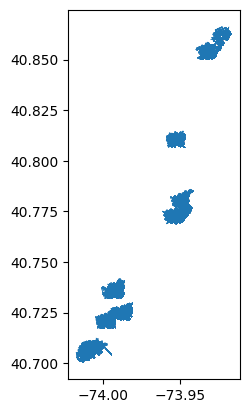

In [25]:
all_iso_gdf.plot()

In [26]:
merged_by_minute = all_iso_gdf.dissolve(by='minutes').reset_index().sort_values('minutes')

final_layers = []
previous_poly = None

for _, row in merged_by_minute.iterrows():
    poly = row.geometry
    if previous_poly:
        ring = poly.difference(previous_poly)
    else:
        ring = poly
    final_layers.append({'minutes': row.minutes, 'geometry':ring})
    previous_poly = poly

final_gdf = gpd.GeoDataFrame(final_layers, crs=f"EPSG:{CRS_GEO}")
final_gdf

,minutes,geometry
0,0.083333,"POLYGON ((-73.94831 40.76974, -73.94829 40.769..."
1,0.166667,"MULTIPOLYGON (((-73.992 40.71749, -73.992 40.7..."
2,0.250000,"MULTIPOLYGON (((-73.99209 40.71742, -73.99209 ..."
3,0.333333,"MULTIPOLYGON (((-73.99201 40.71748, -73.992 40..."
4,0.416667,"MULTIPOLYGON (((-73.99246 40.71747, -73.99246 ..."
...,...,...
176,14.750000,"MULTIPOLYGON (((-74.01722 40.70266, -74.01724 ..."
177,14.833333,"MULTIPOLYGON (((-74.01728 40.70269, -74.01731 ..."
178,14.916667,"MULTIPOLYGON (((-74.01662 40.70373, -74.01669 ..."
179,15.000000,"MULTIPOLYGON (((-74.01736 40.70312, -74.01736 ..."


<Axes: >

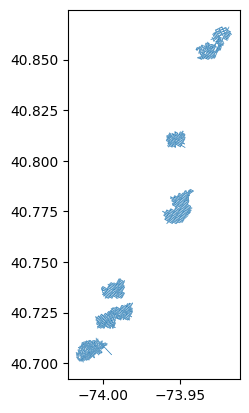

In [27]:
final_gdf.plot()

C:\Users\User\AppData\Local\Temp\ipykernel_19716\1052514506.py:4: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  gpd.GeoSeries([row.geometry]).plot(ax=ax, color=color, alpha=0.8, edgecolor='none')
C:\Users\User\AppData\Local\Temp\ipykernel_19716\1052514506.py:4: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  gpd.GeoSeries([row.geometry]).plot(ax=ax, color=color, alpha=0.8, edgecolor='none')


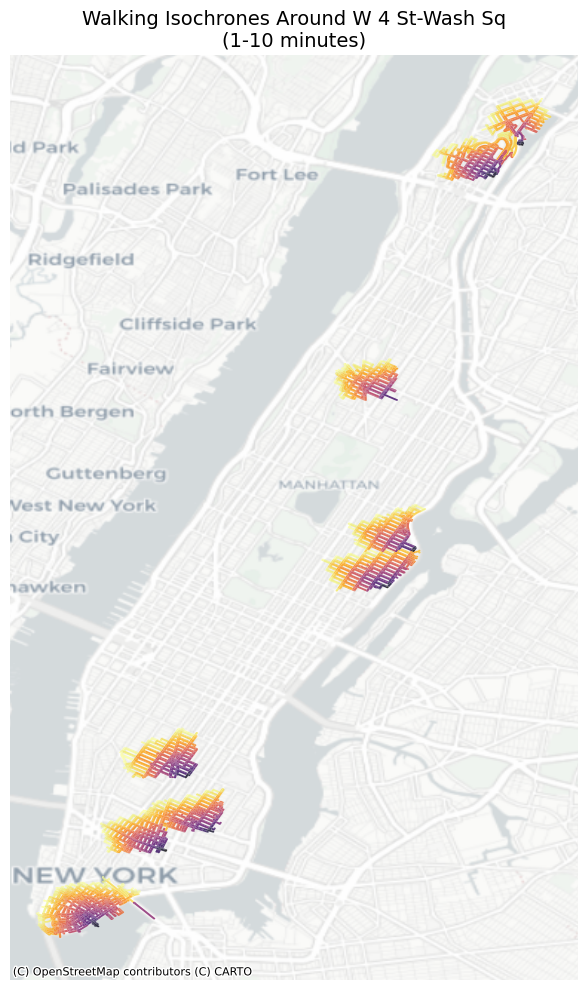

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))
for _, row in final_gdf.sort_values('minutes').iterrows():
    color = plt.cm.inferno(row['minutes'] / final_gdf['minutes'].max())
    gpd.GeoSeries([row.geometry]).plot(ax=ax, color=color, alpha=0.8, edgecolor='none')

cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.CartoDB.Positron)

ax.set_title(f"Walking Isochrones Around {random_stop['stop_name']}\n(1-10 minutes)", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

# Save the Frames

In [53]:
OUT_DIR = '7. frames_isochrones'
os.makedirs(OUT_DIR, exist_ok=True)

merged = all_iso_gdf.dissolve(by='minutes').reset_index().sort_values('minutes')

rings = []
previous_geom = None

for _, row in merged.iterrows():
    geom = row.geometry
    if previous_geom:
        ring = geom.difference(previous_geom)
    else:
        ring = geom
    rings.append({'minutes': row.minutes, 'geometry':ring})
    previous_geom = geom

rings_gdf = gpd.GeoDataFrame(rings, crs=f"EPSG:{CRS_GEO}")

cmap = plt.cm.magma
mins = rings_gdf['minutes'].tolist()
max_min = max(mins)
minute_to_color = {m:cmap(m/max_min) for m in mins}

xmin, ymin, xmax, ymax = rings_gdf.total_bounds
xpad = (xmax - xmin) * 0.04
ypad = (ymax - ymin) * 0.04
xlim = (xmin - xpad, xmax + xpad)
ylim = (ymin - ypad, ymax + ypad)

fig_w, fig_h, dpi = 7, 12, 170
pixel_width = int(fig_w * dpi)
pixel_height = int(fig_h * dpi)

In [ ]:
for i, m in tqdm(enumerate(mins, start=1), total=len(mins), desc='Rendering Frames'):
    fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=dpi)
    
    for mm in mins[:i]:
        geom = rings_gdf.loc[rings_gdf['minutes'] == mm, 'geometry'].values[0]
        if geom.is_empty:
            continue
        gpd.GeoSeries([geom], crs="EPSG:4326").plot(
            ax=ax,
            color=minute_to_color[mm],
            alpha=0.73,
            edgecolor='none',
            zorder=2
        )
        # setting the plot limits
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
        cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.CartoDB.PositronNoLabels, alpha=0.95)

        total_seconds = int(m*60)
        minutes_part = total_seconds // 60
        seconds_part = total_seconds % 60
        label = f"{minutes_part} min {seconds_part} sec"

        ax.text(
            0.02, 0.98, label,
            transform=ax.transAxes, 
            fontsize=22, 
            fontweight='bold',
            color='black',
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=8)
        )

        ax.set_axis_off()
        fig.set_size_inches(fig_w, fig_h)
        fig.set_dpi(dpi)

        out_path = os.path.join(OUT_DIR, f"isochrone_{i:03d}.png")
        fig.savefig(out_path, facecolor='white', bbox_inches='tight')
        plt.close(fig)

Rendering Frames:  15%|████████▉                                                   | 27/181 [27:24<6:07:26, 143.16s/it]

In [ ]:
frames_dir = "7. frames_isochrones"
len(os.listdir(frames_dir))

In [ ]:
mp4_path = '7. manhattan_isochrones.mp4'
frames = sorted([os.path.join(frames_dir, f) for f in os.listdir(frames_dir) if f,endswith('.png')])
images = [imageio.imread(frame) for frame in frames]
imageio.mimsave(mp4_path, images, fps=24, codec='libx264', quality=8, format='FFMPEG')

In [ ]:
from IPython.display import HTML
HTML(f'<viseo src="{mp4_path}" width="500" controls autoplay loop></video>')